In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%pylab inline

account_filename = 'data/accountData.csv'
customer_filename = 'data/customerData.csv'
transaction_filename = 'data/transactions_small_1p.csv'
sanctions_filename = 'data/ctry_sanctions_list.csv'

Populating the interactive namespace from numpy and matplotlib


In [2]:
accounts = pd.read_csv(account_filename)
customers = pd.read_csv(customer_filename)
sanctions = pd.read_csv(sanctions_filename)

In [3]:
transactions = pd.read_csv(transaction_filename)

# Merge all three files

In [4]:
del transactions['Unnamed: 0']

In [5]:
transactions.columns

Index(['TRANSACTION_ID', 'ORIGIN_CUSTOMER_ID', 'ORIGIN_ACCOUNT_ID',
       'TRANSACTION_DATE_TIME', 'TRANSACTION_TYPE', 'TRANSACTION_SOURCE',
       'TRANSACTION_AMOUNT', 'BENEFICIARY_CUSTOMER_ID',
       'BENEFICIARY_ACCOUNT_ID', 'Label'],
      dtype='object')

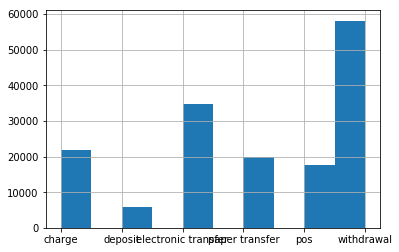

In [6]:
transactions['TRANSACTION_TYPE'].hist()

In [7]:
# if customer, account id is NaN, then use beneficial ids

In [8]:
del transactions['BENEFICIARY_CUSTOMER_ID']
del transactions['BENEFICIARY_ACCOUNT_ID']

In [9]:
transactions.dropna(inplace=True)

In [10]:
transactions = transactions.merge(customers, left_on = 'ORIGIN_CUSTOMER_ID', right_on = 'CUSTOMER_ID')

In [11]:
accounts.head(1)

,ACCOUNT_ID,CUSTOMER_ID,ACCOUNT_DATE_TIME,ACCOUNT_TYPE,ACCOUNT_BALANCE
0,0,0,2016-05-02 03:04:27,basic checkings account,2940588.03


In [12]:
transactions = transactions.merge(accounts, left_on = 'ORIGIN_ACCOUNT_ID', right_on = 'ACCOUNT_ID')

In [13]:
transactions.columns

Index(['TRANSACTION_ID', 'ORIGIN_CUSTOMER_ID', 'ORIGIN_ACCOUNT_ID',
       'TRANSACTION_DATE_TIME', 'TRANSACTION_TYPE', 'TRANSACTION_SOURCE',
       'TRANSACTION_AMOUNT', 'Label', 'CUSTOMER_ID_x', 'CUSTOMER_TYPE',
       'COUNTRY', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_ID', 'CUSTOMER_ID_y',
       'ACCOUNT_DATE_TIME', 'ACCOUNT_TYPE', 'ACCOUNT_BALANCE'],
      dtype='object')

In [14]:
transactions.drop(['TRANSACTION_ID', 
                   'ORIGIN_CUSTOMER_ID',
                   'ORIGIN_ACCOUNT_ID',
                   'TRANSACTION_DATE_TIME',
                   'CUSTOMER_ID_x',
                   'ACCOUNT_ID',
                   'CUSTOMER_ID_y',
                   'ACCOUNT_DATE_TIME'], axis = 1, inplace=True)

In [15]:
transactions.columns

Index(['TRANSACTION_TYPE', 'TRANSACTION_SOURCE', 'TRANSACTION_AMOUNT', 'Label',
       'CUSTOMER_TYPE', 'COUNTRY', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_TYPE',
       'ACCOUNT_BALANCE'],
      dtype='object')

In [16]:
categorical_features = ['TRANSACTION_TYPE', 
                        'TRANSACTION_SOURCE',
                        'CUSTOMER_TYPE', 
                        'COUNTRY',
                        'ACCOUNT_TYPE']

In [17]:
for feature in categorical_features:
    transactions[feature] = transactions[feature].astype('category')

In [18]:
skewed_numerical_features = ['TRANSACTION_AMOUNT',
                             'ACCOUNT_BALANCE']

In [19]:
transactions[skewed_numerical_features] = transactions[skewed_numerical_features].apply(lambda x: np.log(x + 1))

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_features = ['TRANSACTION_AMOUNT',
                      'CUSTOMER_RISK_SCORE',
                      'ACCOUNT_BALANCE']
transactions[numerical_features] = scaler.fit_transform(transactions[numerical_features])

In [21]:
sanctions_list = list(sanctions['Sanctions, Countries'])

In [22]:
transactions['Sanction'] = (transactions['COUNTRY'].apply(lambda ctry: ctry in sanctions_list)).astype(int)

In [23]:
del transactions['COUNTRY']

In [24]:
transactions.columns

Index(['TRANSACTION_TYPE', 'TRANSACTION_SOURCE', 'TRANSACTION_AMOUNT', 'Label',
       'CUSTOMER_TYPE', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_TYPE',
       'ACCOUNT_BALANCE', 'Sanction'],
      dtype='object')

In [25]:
transactions = pd.get_dummies(transactions)

In [26]:
len(transactions.columns)

22

In [27]:
labels = transactions['Label']

In [28]:
transactions.to_csv('data/transactions_small_1p_all_features.csv')

# Data Exploration

In [29]:
transactions.columns

Index(['TRANSACTION_AMOUNT', 'Label', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_BALANCE',
       'Sanction', 'TRANSACTION_TYPE_charge',
       'TRANSACTION_TYPE_electronic transfer',
       'TRANSACTION_TYPE_paper transfer', 'TRANSACTION_TYPE_pos',
       'TRANSACTION_TYPE_withdrawal', 'TRANSACTION_SOURCE_ach credit',
       'TRANSACTION_SOURCE_ach debit', 'TRANSACTION_SOURCE_atm',
       'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online',
       'TRANSACTION_SOURCE_p2p', 'TRANSACTION_SOURCE_swift',
       'TRANSACTION_SOURCE_teller', 'CUSTOMER_TYPE_Business',
       'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account',
       'ACCOUNT_TYPE_interest checking account'],
      dtype='object')

In [30]:
small_set = transactions.sample(frac=0.1)

In [31]:
corrs = small_set.corr()

In [32]:
#pd.plotting.scatter_matrix(small_set, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corrs.sort_values('Label', ascending = False);
reduced_features = list(corrs[corrs['Label'] > 0].index)
print(reduced_features)

['TRANSACTION_AMOUNT', 'Label', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_BALANCE', 'Sanction', 'TRANSACTION_TYPE_charge', 'TRANSACTION_TYPE_pos', 'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online', 'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account']


In [33]:
print(len(list(transactions.columns)))
print(list(transactions.columns))
feature = list(transactions.columns)[8]
print(feature)

22
['TRANSACTION_AMOUNT', 'Label', 'CUSTOMER_RISK_SCORE', 'ACCOUNT_BALANCE', 'Sanction', 'TRANSACTION_TYPE_charge', 'TRANSACTION_TYPE_electronic transfer', 'TRANSACTION_TYPE_paper transfer', 'TRANSACTION_TYPE_pos', 'TRANSACTION_TYPE_withdrawal', 'TRANSACTION_SOURCE_ach credit', 'TRANSACTION_SOURCE_ach debit', 'TRANSACTION_SOURCE_atm', 'TRANSACTION_SOURCE_merchant location', 'TRANSACTION_SOURCE_online', 'TRANSACTION_SOURCE_p2p', 'TRANSACTION_SOURCE_swift', 'TRANSACTION_SOURCE_teller', 'CUSTOMER_TYPE_Business', 'CUSTOMER_TYPE_Individual', 'ACCOUNT_TYPE_basic checkings account', 'ACCOUNT_TYPE_interest checking account']
TRANSACTION_TYPE_pos


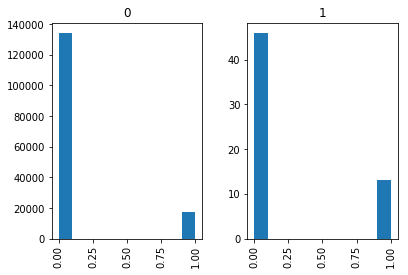

In [34]:
# transactions.groupby('Label')[feature].hist();
transactions.hist(feature, by='Label');

In [35]:
transactions = transactions[reduced_features]

In [36]:
transactions.head(1)

,TRANSACTION_AMOUNT,Label,CUSTOMER_RISK_SCORE,ACCOUNT_BALANCE,Sanction,TRANSACTION_TYPE_charge,TRANSACTION_TYPE_pos,TRANSACTION_SOURCE_merchant location,TRANSACTION_SOURCE_online,CUSTOMER_TYPE_Individual,ACCOUNT_TYPE_basic checkings account
0,0.065694,0,0.209302,0.918079,0,0,1,1,0,1,1


In [37]:
transactions.to_csv('data/reduced_transactions_1p.csv')

# Gaussian Mixture

In [38]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

In [39]:
from sklearn.mixture import GaussianMixture

clusterer = GaussianMixture(n_components=1).fit(transactions)

preds = clusterer.predict(transactions)

centers = clusterer.means_

0